# 1D Shock Tube Simulation in SPH 
---

## Problem description

### Presentation

A infinite-length tube with a negligible section is considered, making it a one-dimensional problem. It is filled with a compressible yet non-viscous gaz, spread in two different zones separated by a thin layer. The first one, on the left is under pressure, while the second is at rest. At $t=t_0$, one removes the thin layer and we study the evolution of the gaz. 

The non-viscosity of the fluid allows us to use the Euler equations, instead of the Navier-Stokes ones, which are a bit more complicated to use. This system of equations handles the conservation of three quantities: linear momentum, mass and energy. Following the SPH method, we use a Lagrangian form of these equations, meaning that the coordinates are moving with the material, in contradiction to the Eulerian formulation. This introduces the notion of total temporal derivation, denoted $D_t$, and defined as following, with $\partial_t$ being the partial derivation with respect of time, $\bold{v}$ the velocity vector and $\nabla$ the gradient differential operator.

### Data
We consider 400 particles with same mass of $m=0.001875$. 320 particles occupy the left zone $x \in [-0.6,0.0]$, while 80 are in the rest zone $x \in [0.0,0.6]$.

At $t=0$, whe have the following initial conditions, first for the particles on the left:
\begin{align*}
    \rho &= 1 \\
    v &= 0 \\
    u &= 2.5 \\
    p &= 1
\end{align*}
And on the right:
\begin{align*}
    \rho &= 0.25 \\
    v &= 0 \\
    u &= 1.795 \\
    p &= 0.1795
\end{align*}

This leads to writing the initial data as following :

In [1]:
const LEFT_PARTICLES_COUNT = 320
const RIGHT_PARTICLES_COUNT = 80
const PARTICLES_COUNT = LEFT_PARTICLES_COUNT + RIGHT_PARTICLES_COUNT

const FIXED_SIDES_PARTICLES_COUNT = 20

const RIGHT_MIN = 0
const RIGHT_MAX = 0.6
const LEFT_MIN = -0.6
const LEFT_MAX = RIGHT_MIN - (RIGHT_MIN - LEFT_MIN) / (LEFT_PARTICLES_COUNT + 2)

const LEFT_DENSITY = 1.0
const LEFT_VELOCITY= 0.0
const LEFT_ENERGY = 2.5
const LEFT_PRESSURE = 1.0

const RIGHT_DENSITY = 0.25
const RIGHT_VELOCITY= 0.0
const RIGHT_ENERGY = 1.795
const RIGHT_PRESSURE = 0.1795

const PARTICLE_MASS = 0.001875
const GAMMA = 1.4

const DX = 0.6/80
const HSML = 2.0 * DX;

### Time handling and smoothing length
We're using 40 iterations of $\Delta t = 0.005$, with a final time of $t=0.2$. The smoothing length is chosen to be constant at $h=0.016$.


In [2]:
const TIME_STEPS = 40
const TIME_DELTA = 0.005;

### Particles generation with their respective quantities

In [3]:
function generateQuantities()
    # Position
    x = append!(
        [(i)*DX/4 + LEFT_MIN for i in 1:LEFT_PARTICLES_COUNT],
        [(i-LEFT_PARTICLES_COUNT-1)*DX + DX/2 for i in LEFT_PARTICLES_COUNT+1:PARTICLES_COUNT]
    )
    # Density
    ρ = append!(LEFT_DENSITY .* ones(LEFT_PARTICLES_COUNT), RIGHT_DENSITY .* ones(RIGHT_PARTICLES_COUNT))
    # Energy
    u = append!(LEFT_ENERGY .* ones(LEFT_PARTICLES_COUNT), RIGHT_PRESSURE .* ones(RIGHT_PARTICLES_COUNT))
    # Velocity
    v = zeros(PARTICLES_COUNT)
    # Pressure
    p = append!(LEFT_PRESSURE .* ones(LEFT_PARTICLES_COUNT), RIGHT_PRESSURE .* ones(RIGHT_PARTICLES_COUNT))

    (x, ρ, u, v, p)
    end

generateQuantities (generic function with 1 method)

## Smoothing kernel

In [4]:
# X.F. Yang's Double Cosine kernel (2013)
function doublecosine(r, h)
    # Kernel constant
    k = 2
    if abs(r) < 2h
        # Normalizing factor
        σ = 1/(6k * h)

        # Checking sign
        sign = r == 0 ? 1 : r/abs(r)

        # Kernel computation
        W = (4cos(π/(2h) * r) + cos(π/h * r) + 3) * σ

        # Derivatives computation
        ∂x_W = (4π/(2h) * sin(π/(2h) * r) + π/h * sin(π/h * r)) * -sign * σ

        return (W,∂x_W)
    else
        return (0,0)
    end
    res
end

# J.J. Monaghan's Cubic Spline kernel (1992)
function cubicspline(r, h)
    if abs(r) < 2h
        # Reduced radius
        q = r/h

        # Normalizing factor
        σ = 2/(3h)

        # Checking sign
        sign = r == 0 ? 1 : r/abs(r)

        if abs(r) < h
            # Kernel computation
            W = (1 - 1.5q^2 + 0.75q^3) * σ

            # Derivatives computation
            ∂x_W = (2q - 1.5q^2) * sign/h^2

        else #if h <abs(r) < 2h
            # Kernel computation
            W = (2-q)^3/4 * σ

            # Derivatives computation
            ∂x_W = (q-2)^2/2 * sign/h^2
        end
        return (W,∂x_W)
    else
        return (0,0)
    end
    res
end

cubicspline (generic function with 1 method)

## SPH step

### Neighbouring particles finding: the DirectFind algorithm

In [5]:
function directfind(x)
    pairs = []
    W = []
    ∂x_W = []

    for i in 1:PARTICLES_COUNT-1
        for j in i+1:PARTICLES_COUNT
            r = x[i] - x[j]
            if abs(r) < 2 * 2HSML
                # Saving the interacting pair
                push!(pairs, (i, j))

                # Computing and saving the corresponding smoothing kernel value
                (W_k, ∂x_W_k) = doublecosine(r, HSML)
                push!(W, W_k)
                push!(∂x_W, ∂x_W_k)
            end
        end
    end

    (W_0, _) = doublecosine(0, HSML)

    (pairs, W, ∂x_W, W_0)
end

directfind (generic function with 1 method)

### The SPH density approximation

In [6]:
function computedensity(pairs, W, W_0)
    # Considering the self effect
    ρ = ones(PARTICLES_COUNT) * PARTICLE_MASS * W_0

    # Computing for the neighbours
    for k in 1:length(pairs)
        (i, j) = pairs[k]
        ρ[i] += W[k] * PARTICLE_MASS
        ρ[j] += W[k] * PARTICLE_MASS
    end

    ρ
end

computedensity (generic function with 1 method)

### Compute SPH operands

In [8]:
function computeoperands(ρ, p, v, pairs, ∂x_W)
    # Zero-initialization, since ∂x_W(0) = 0
    L = zeros(PARTICLES_COUNT)
    H = zeros(PARTICLES_COUNT)

    # Computing with the neighbours
    for k in 1:length(pairs)
        # Getting pairs
        (i, j) = pairs[k]

        # Calculating the constant term
        p_ij = p[i]/ρ[i]^2 + p[j]/ρ[j]^2

        # Wrapping for L and both particles, remembering ∂x_W_ij = -∂x_W_ji
        L[i] += ∂x_W[k] * p_ij * PARTICLE_MASS
        L[j] -= ∂x_W[k] * p_ij * PARTICLE_MASS

        # Wrapping for L and both particles, remembering ∂x_W_ij = -∂x_W_ji
        H[i] -= ∂x_W[k] * 0.5 * (v[i] - v[j]) * p_ij * PARTICLE_MASS
        H[j] += ∂x_W[k] * 0.5 * (v[j] - v[i]) * p_ij * PARTICLE_MASS
    end

    (L, H)
end

computeoperands (generic function with 1 method)

### Retrieve artificial viscosity contribution

In [9]:
function correctwithartviscosity(x, ρ, p, v, pairs, ∂x_W, L, H)
    # Constants
    qa = 1
    qb = 1
    etq = 0.1

    # Initialization of the corrections
    art_L = zeros(PARTICLES_COUNT)
    art_H = zeros(PARTICLES_COUNT)

    # Looping over pairs
    for k in 1:length(pairs)
        # Getting pairs
        (i, j) = pairs[k]

        x_ij = x[i] - x[j]
        v_ij = v[i] - v[j]

        xpsv = v_ij * x_ij
        xpsx = x_ij^2

        if (xpsv < 0)
            # Intermediary results
            muv = HSML * xpsv / (xpsx + HSML^2 * etq^2)
            mc = (sqrt(abs(GAMMA * p[i]/ρ[i])) + sqrt(abs(GAMMA * p[j]/ρ[j]))) / 2
            ρ_m = (ρ[i] + ρ[j]) / 2
            piv = (qb * muv - qa * mc) * muv/ρ_m
            hx = -piv * ∂x_W[k]

            # Adding to artificial acceleration contribution
            art_L[i] += PARTICLE_MASS * hx
            art_L[j] -= PARTICLE_MASS * hx

            # Adding to artificial energy contribution
            art_H[i] += v_ij / 2 * PARTICLE_MASS * hx
            art_H[j] -= -v_ij / 2 * PARTICLE_MASS * hx
        end
    end

    # Applying the contribution
    L -= art_L
    H -= art_H

    (L, H)
end

correctwithartviscosity (generic function with 1 method)

### Wrapping up

In [11]:
function doSPHmagic(x, ρ, u, v, p, L, H)

    # 1 - DirectFind algorithm to find interacting particles
    (pairs, W, ∂x_W, W_0) = directfind(x)

    # 2 - SPH density approximation
    ρ = computedensity(pairs, W, W_0)

    # 3 - Equation of state for ideal gases
    p = (u .* ρ) * (GAMMA - 1)

    # 4,5 - Compute L,H operands
    (L, H) = computeoperands(ρ, p, v, pairs, ∂x_W)

    # 6 - Add artificial viscosity contribution
    (L, H) = correctwithartviscosity(x, ρ, p, v, pairs, ∂x_W, L, H)

    (x, ρ, u, v, p, L, H)
end

doSPHmagic (generic function with 1 method)

### Simulation step

In [36]:
function computeSimulationStep(step, x, ρ, u, v, p, L, H)
    # First Leap-Frog integration
    if step > 1
        # Keep track of previous energy and velocity
        previous_u = copy(u)
        previous_v = copy(v)

        # Compute half-step integration
        for i in FIXED_SIDES_PARTICLES_COUNT:PARTICLES_COUNT-FIXED_SIDES_PARTICLES_COUNT
            u[i] += TIME_DELTA/2 * H[i]
            v[i] += TIME_DELTA/2 * L[i]
        end
    end

    (x, ρ, u, v, p, L, H) = doSPHmagic(x, ρ, u, v, p, L, H)

    # Second Leap-Frog integration
    for i in FIXED_SIDES_PARTICLES_COUNT:PARTICLES_COUNT-FIXED_SIDES_PARTICLES_COUNT
        if step > 1
            # Compute half-step integration with previous value
            u[i] = previous_u[i] + TIME_DELTA * H[i]
            v[i] = previous_v[i] + TIME_DELTA * L[i]
        else
            # Compute first half-step integration
            u[i] += TIME_DELTA * H[i]
            v[i] += TIME_DELTA * L[i]
        end
        # Compute regular integration
        x[i] += TIME_DELTA * v[i]
    end

    (x, ρ, u, v, p, L, H)
end

computeSimulationStep (generic function with 1 method)

## Final solver

In [37]:
function runsimulation()
    # Initial quantities
    (x, ρ, u, v, p) = generateQuantities()
    #writecsvstep(0, x, ρ, u, v, p)
    #println("Step $(0)")
    #gr()
    #plot(x, ρ)

    # SPH operands
    L = zeros(PARTICLES_COUNT)
    H = zeros(PARTICLES_COUNT)

    # Simulation steps
    for step in 1:TIME_STEPS
        (x, ρ, u, v, p, L, H) = computeSimulationStep(step, x, ρ, u, v, p, L, H)
        #writecsvstep(step, x, ρ, u, v, p)
        #println("Step $(step)")
    end

    (x, ρ, u, v, p)
end

runsimulation (generic function with 1 method)

In [51]:
(x, ρ, u, v, p) = runsimulation();

## Results at the end of the simulation

Enabling plotting

In [50]:
using Plots

# Choosing default backend
gr()

Plots.GRBackend()

### Density

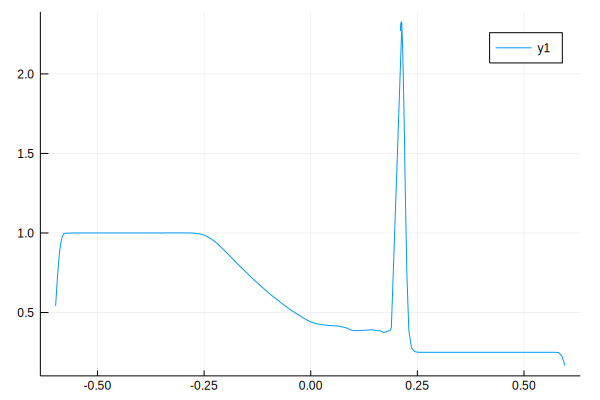

In [43]:
plot(x,ρ)

### Energy

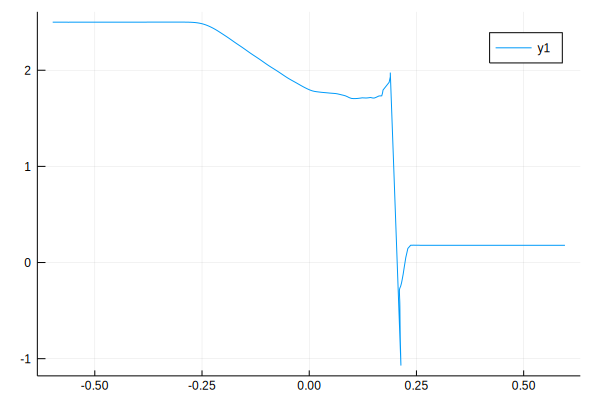

In [44]:
plot(x, u)

### Velocity

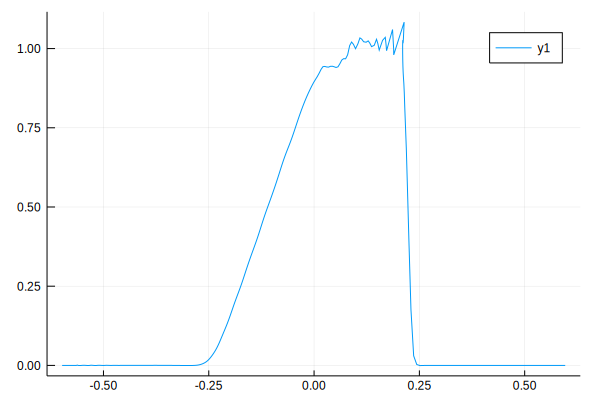

In [45]:
plot(x, v)

### Pressure

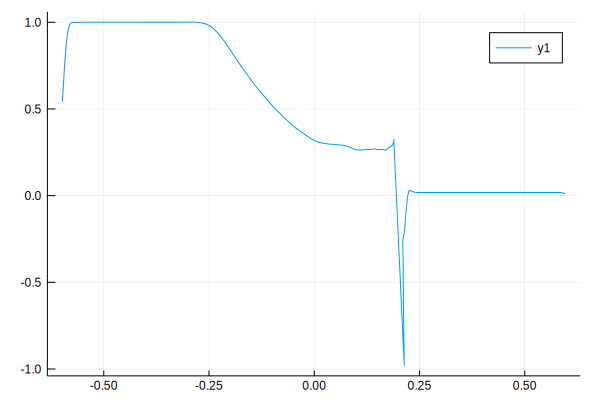

In [46]:
plot(x, p)